In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid,KFold
from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from ipywidgets import IntProgress
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


# Load data

In [ ]:
DIR  = "/gdrive/MyDrive/Data_Science_Projekte/earth_quake_damage_dd/"

train_values = pd.read_csv(DIR+'data/train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DIR+'data/train_labels.csv', index_col='building_id')
test_values  = pd.read_csv(DIR+"data/test_values.csv", index_col='building_id')
submission_format = pd.read_csv(DIR+"data/submission_format.csv", index_col='building_id')

train_data = train_values.join(train_labels)
train_data.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


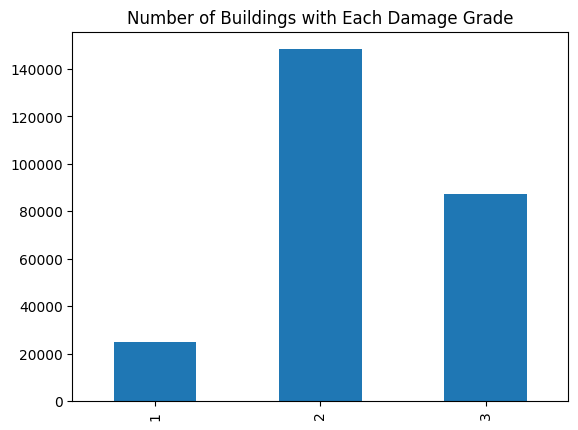

In [ ]:
(train_labels.damage_grade.value_counts().sort_index()
    .plot.bar(title="Number of Buildings with Each Damage Grade"))
plt.show()

In [ ]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

# Geo Embedding

In [ ]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [ ]:
# Step 1: Label Encoding
X = pd.concat([train_values, test_values]).loc[:,geo_features].drop_duplicates()

label_encoders = {}
encoded_data = {}

for column in X.columns:
    le = LabelEncoder()
    encoded_data[column] = le.fit_transform(X[column])
    label_encoders[column] = le

encoded_df = pd.DataFrame(encoded_data)

input_data = torch.tensor(encoded_df.values, dtype=torch.long)
output_data = input_data.clone()

In [ ]:
for column in X.columns:
  print(X.loc[:, column].unique().size)

31
1418
11861


In [ ]:
# Step 2: Define the Neural Network

emb_dim = 32

class GeoEncoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=emb_dim,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.geo_lv1_embedder = nn.Embedding(num_classes1, 8) #16
        self.geo_lv2_embedder = nn.Embedding(num_classes2, 16) #512
        self.geo_lv3_embedder = nn.Embedding(num_classes3, 32) #1024
        self.compressor = torch.nn.Linear(8+16+32, emb_dim)

    def forward(self, x):
        x_1 = self.geo_lv1_embedder(x[:, 0])
        x_2 = self.geo_lv2_embedder(x[:, 1])
        x_3 = self.geo_lv3_embedder(x[:, 2])
        x = torch.cat((x_1, x_2, x_3), dim=1)
        x = torch.nn.functional.relu(x)
        return self.compressor(x)

class GeoDecoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=emb_dim,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.geo_lv1_predictor = nn.Linear(emb_dim, num_classes1)
        self.geo_lv2_predictor = nn.Linear(emb_dim, num_classes2)
        self.geo_lv3_predictor = nn.Linear(emb_dim, num_classes3)

    def forward(self, x):
        x1 = self.geo_lv1_predictor(x)
        x2 = self.geo_lv2_predictor(x)
        x3 = self.geo_lv3_predictor(x)
        return x1, x2, x3

class GeoEncoderDecoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=emb_dim,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.encoder = GeoEncoderModel(emb_dim, num_classes1, num_classes2, num_classes3)
        self.decoder = GeoDecoderModel(emb_dim, num_classes1, num_classes2, num_classes3)

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.relu(x)
        x1, x2, x3 = self.decoder(x)
        return x1, x2, x3

In [ ]:
# Step 3: Training

# Create the neural network model
model = GeoEncoderDecoderModel().to(DEVICE)

batch_size = 512  # You can adjust this based on your available memory and computational resources
dataset = TensorDataset(input_data, output_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterions = []
for column in geo_features:
    weight = compute_class_weight('balanced',
                                  classes=X[column].unique(),
                                  y=X[column].values
    )
    weight = torch.tensor(weight, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight)
    criterions.append(criterion)

# Train the model
num_epochs = 500  # You can adjust this based on your data size and convergence
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = 0
        for i in range(3):
          loss += criterions[i](outputs[i], targets[:,i])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if ((epoch % 50 == 0) or (epoch == num_epochs -1)):
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.6f}")


Epoch [1/500], Loss: 20.050174
Epoch [51/500], Loss: 0.314630
Epoch [101/500], Loss: 0.042118
Epoch [151/500], Loss: 0.013513
Epoch [201/500], Loss: 0.005541
Epoch [251/500], Loss: 0.002515
Epoch [301/500], Loss: 0.001207
Epoch [351/500], Loss: 0.000591
Epoch [401/500], Loss: 0.000296
Epoch [451/500], Loss: 0.000150
Epoch [500/500], Loss: 0.000077


In [ ]:
# Step 4: Extract the Embedding
# Now that the model is trained, you can get the embeddings for your original data

for df in [train_values, test_values]:
    encoded_data = {}

    for column in geo_features:
        le = label_encoders[column]
        encoded_data[column] = le.transform(df[column])

    encoded_df = pd.DataFrame(encoded_data)

    input_data = torch.tensor(encoded_df.values, dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        embedding = torch.relu(model.encoder(input_data))

    embedding = np.array(embedding.to('cpu'))

    for j in range(emb_dim):
        df ['geo_' + str(j+1)] = embedding[:,j]

    df.drop(columns=geo_features, inplace=True)

In [ ]:
train_values.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,geo_23,geo_24,geo_25,geo_26,geo_27,geo_28,geo_29,geo_30,geo_31,geo_32
building_id,,,,,,,,,,,,,,,,,,,,,
802906,2,30,6,5,t,r,n,f,q,t,...,6.144701,8.904431,21.432377,14.453499,18.578915,12.277641,8.098637,9.999624,6.021489,7.187561
28830,2,10,8,7,o,r,n,x,q,s,...,13.901266,19.942364,10.614307,12.559460,21.511990,18.132734,28.463596,16.503988,19.824400,4.384967
94947,2,10,5,5,t,r,n,f,x,t,...,10.814566,17.173151,8.140594,16.279848,6.516877,8.650904,14.728860,13.150227,13.368773,8.778214
590882,2,10,6,5,t,r,n,f,x,s,...,12.063419,2.385465,15.327884,11.865688,12.261857,19.103645,23.763420,12.548151,10.942965,12.752030
201944,3,30,8,9,t,r,n,f,x,s,...,8.177800,0.000000,18.830048,10.437095,11.674156,10.112645,8.602537,19.929420,7.734726,16.764158


In [ ]:
#torch.save(model.encoder.state_dict(), DIR + 'geo_embedding_32.pt')

# Search for best hyperparameters

In [ ]:
param_grid = {'objective': ['multi:softmax'],
              'random_state': [42],
              'n_estimators': [600, 800],
              'learning_rate': [0.03, 0.04],
              'max_depth': [12, 14],
              'min_child_weight':[50],
              'min_split_loss': [0],
              'colsample_bytree': [0.75, 0.8]
}

param_list = list(ParameterGrid(param_grid))

print('Size of ParameterGrid: ', len(param_list))

Size of ParameterGrid:  16


In [ ]:
X = pd.get_dummies(train_values)
y = train_labels.values.ravel() - 1

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

best_score = 0
results = []

f = IntProgress(min=0, max=len(param_list)) #progress bar
display(f)

for i, params in enumerate(param_list):
    if DEVICE == "cuda":
        xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', **params)
    else:
        xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)

    df = pd.DataFrame(data=params, index = [i])

    pred_y_train = xgb_model.predict(X_train)
    train_score = f1_score(y_train, pred_y_train, average='micro')
    df['train_score'] = train_score

    pred_y_val = xgb_model.predict(X_val)
    val_score = f1_score(y_val, pred_y_val, average='micro')
    df['val_score'] = val_score

    results.append(df)

    if val_score > best_score:
        best_score = val_score
        best_model = xgb_model
        best_params = params

    f.value += 1

IntProgress(value=0, max=16)

In [ ]:
df_results = pd.concat(results).drop(columns=['objective', 'random_state'])
df_results.sort_values(by='val_score', inplace=True, ascending=False)
df_results.head(10)

,colsample_bytree,learning_rate,max_depth,min_child_weight,min_split_loss,n_estimators,train_score,val_score
6,0.75,0.04,14,50,0,600,0.834018,0.750580
14,0.80,0.04,14,50,0,600,0.834349,0.750177
4,0.75,0.04,12,50,0,600,0.818323,0.750120
13,0.80,0.04,12,50,0,800,0.830353,0.750120
15,0.80,0.04,14,50,0,800,0.847362,0.750082
1,0.75,0.03,12,50,0,800,0.818189,0.749890
10,0.80,0.03,14,50,0,600,0.822554,0.749851
11,0.80,0.03,14,50,0,800,0.834205,0.749794
5,0.75,0.04,12,50,0,800,0.829792,0.749736
12,0.80,0.04,12,50,0,600,0.818155,0.749736


In [ ]:
# Choose best 3 parameter
hyperparameter = ['colsample_bytree', 'learning_rate', 'max_depth', 'min_child_weight', 'min_split_loss', 'n_estimators']
df = df_results.iloc[:3,:].loc[:, hyperparameter]
df['objective'] = 'multi:softmax'
df['random_state'] = 42
best_param_list = df.to_dict('records')

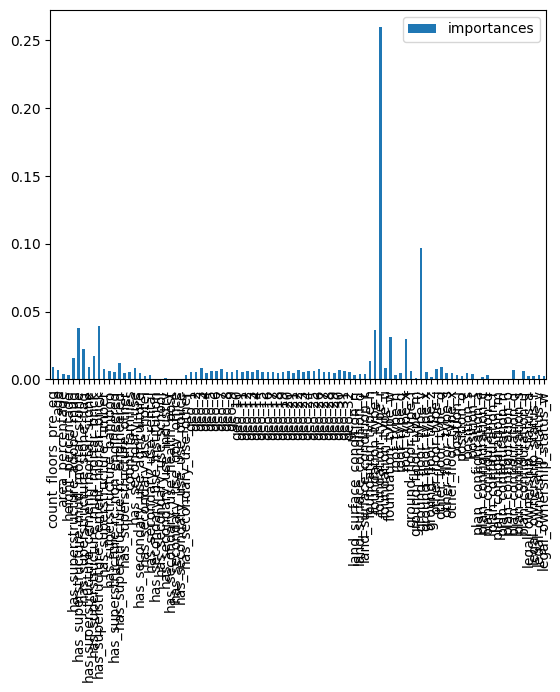

<Figure size 1000x600 with 0 Axes>

In [ ]:
#get feature importances and graph, could look further into thesee to improve the model further
df_importances=pd.DataFrame(best_model.feature_importances_)
df_importances.index=X.columns
df_importances.columns=['importances']
df_importances.plot.bar()
plt.figure(figsize=(10, 6))
plt.show()

In [ ]:
X = pd.get_dummies(train_values)
y = train_labels.values.ravel() - 1

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

f = IntProgress(min=0, max=5* len(best_param_list)) #progress bar
display(f)

for i, params in enumerate(best_param_list):
    train_scores = []
    val_scores = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        if DEVICE == "cuda":
          xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', **params)
        else:
          xgb_model = xgb.XGBClassifier(**params)
        xgb_model.fit(X_train, y_train)

        train_y_pred = xgb_model.predict(X_train)
        train_scores.append(f1_score(y_train, train_y_pred, average='micro'))

        val_y_pred = xgb_model.predict(X_test)
        val_scores.append(f1_score(y_test, val_y_pred, average='micro'))

        f.value += 1

    df = pd.DataFrame(data=params, index = [i])
    df['train_score'] = np.mean(train_scores)
    df['val_score'] = np.mean(val_scores)
    results.append(df)

IntProgress(value=0, max=15)

In [ ]:
df_results = pd.concat(results)
df_results.sort_values(by='val_score', inplace=True, ascending=False)
df_results.drop(columns=['objective', 'random_state'])

,colsample_bytree,learning_rate,max_depth,min_child_weight,min_split_loss,n_estimators,train_score,val_score
0,0.75,0.04,14,50,0,600,0.833606,0.751398
1,0.80,0.04,14,50,0,600,0.833765,0.750945
2,0.75,0.04,12,50,0,600,0.818719,0.750861


In [ ]:
best_params = df_results.drop(columns=['train_score', 'val_score']).to_dict('records')[0]

# Final training and prediction

In [ ]:
X_train = pd.get_dummies(train_values)
X_test = pd.get_dummies(test_values)
y_train = train_labels.values.ravel() - 1

if DEVICE == "cuda":
    xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',**best_params)
else:
    xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

pred_y_train = xgb_model.predict(X_train)
train_score = f1_score(y_train, pred_y_train, average='micro')
print('training score: {0: .5f}'.format(train_score))

In [ ]:
predictions = xgb_model.predict(X_test) + 1

# Save submission

In [ ]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

In [ ]:
my_submission.to_csv(DIR+'submissions/submission_geo_embedding.csv')